# CNN with Keras on CIFAR10

## Loading the packages

In [1]:
# First, import TF and get its version.
# !pip install --upgrade tensorflow
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [0]:
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# ... import here the different keras libraries you need
from tensorflow.keras.datasets import  cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras import utils
from tensorflow.keras import regularizers


%matplotlib inline

## Loading the raw data

170500096/170498071 [==============================] - 2s 0us/step


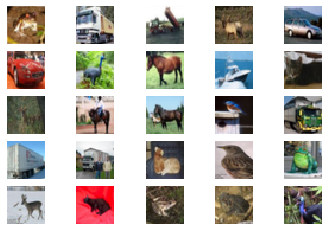

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,5):
        for j in range(0,5):
            plt.subplot2grid((5,5),(i,j))
            plt.imshow(X[k], cmap='gray')
            k = k+1
            plt.axis('off')
    plt.show()
    
# Load data & split data between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

show_imgs(X_train)
print(X_train.shape)
print(X_test.shape)

In [6]:
X_train =  X_train.astype('float32')                     # ... change the type towards float32
X_test =   X_test.astype('float32')                      # ... idem

max = np.max(X_train)
min = np.min(X_train)
X_train = 2*((X_train- min)/(max-min))-1                 # ... normalize the range to be between 0.0 and 1.0
X_test =  2*((X_test- min)/(max-min))-1                  # ...

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


50000 train samples
10000 test samples
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.


In [7]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)  # modify targets to 1-hot using utils.to_categorical()
Y_test = utils.to_categorical(y_test, n_classes)    # idem 
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define, Compile and Train the model

In [49]:
E = 30                   # number of epochs
B = 128                  # batch size
S = 1

# ... define the model as a Sequential type

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=n_classes, activation='softmax'))

# ... print model infomration with summary() method
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)      

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ... call the training with the fit() function giving the tensors as 
#     inputs, defining batch size, number of epochs and validation data
start_time = time.time()
log = model.fit(X_train, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(X_test, Y_test))
print("--- %s seconds ---" % (time.time() - start_time))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 402s 8ms/sample - loss: 1.6926 - accuracy: 0.3718 - val_loss: 1.3413 - val_accuracy: 0.5074
Epoch 2/30
50000/50000 [==============================] - 402s 8ms/sample - loss: 1.2720 - accuracy: 0.5419 - val_loss: 1.1912 - val_accuracy: 0.5757
Epoch 3/30
50000/50000 [==============================] - 402s 8ms/sample - loss: 1.0697 - accuracy: 0.6226 - val_loss: 0.9017 - val_accuracy: 0.6808
Epoch 4/30
50000/50000 [==============================] - 402s 8ms/sample - loss: 0.9463 - accuracy: 0.6694 - val_loss: 0.8025 - val_accuracy: 0.7219
Epoch 5/30
50000/50000 [==============================] - 402s 8ms/sample - loss: 0.8555 - accuracy: 0.7035 - val_loss: 0.7298 - val_accuracy: 0.7470
Epoch 6/30
50000/50000 [==============================] - 401s 8ms/sample - loss: 0.7879 - accuracy: 0.7277 - val_loss: 0.7034 - val_accuracy: 0.7560
Epoch 7/30
50000/50000 [==========================

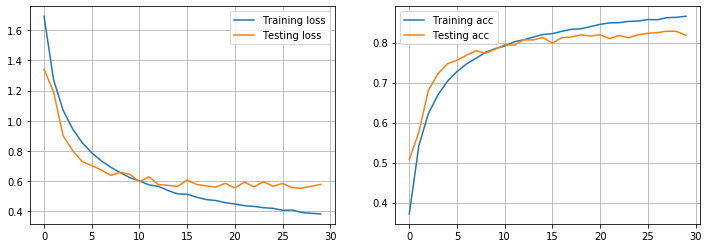

In [51]:
# Loss evaluation during training
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [52]:
# Model evaluation
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0) # ... evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.5790350922584534
Test accuracy: 0.8182
